In [15]:
import os
import re
import random
import numpy as np
import pandas as pd
from collections import defaultdict
from typing import List, Dict, Set
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoTokenizer, RobertaModel, get_linear_schedule_with_warmup
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score
try:
    import emoji
except Exception:
    emoji = None

In [16]:
MODEL_NAME = "FacebookAI/roberta-base"
SAVE_DIR = "roberta_early_fusion"
EMOTIONS_FILE = "emotions.txt"
LEXICON_XLS = "inquireraugmented.xls"

STOPWORDS_FILE = "Models/data/stopwords.txt"
CONTRACTIONS_FILE = "Models/data/contractions.json"
EMOTICON_FILE = "Models/data/emoticons.json"
SLANG_FILE = "Models/data/slang.json"
EMOTION_TO_GI_FILE = "Models/data/emotion_to_gi.json"

BATCH_SIZE = 32
MAX_LENGTH = 256
NUM_EPOCHS = 1000
LR = 1e-5
DROPOUT = 0.3
SEEDS = [1, 2, 10, 21, 42]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GI_EMBED_DIM = 64
USE_HYBRID_LATE_FUSION = True
L2_REG = 0.05

In [17]:
with open(STOPWORDS_FILE, "r", encoding="utf-8") as f:
    stop_words = set(line.strip().lower() for line in f if line.strip())
with open(CONTRACTIONS_FILE, "r", encoding="utf-8") as f:
    CONTRACTIONS = json.load(f)
with open(EMOTICON_FILE, "r", encoding="utf-8") as f:
    EMOTICON_MAP = json.load(f)
with open(SLANG_FILE, "r", encoding="utf-8") as f:
    SLANG_MAP = json.load(f)
with open(EMOTION_TO_GI_FILE, "r", encoding="utf-8") as f:
    emotion_to_gi = json.load(f)

punct_keep = set(["!", "?"])

In [18]:
def preprocess_text(text: str, remove_stopwords: bool = False) -> str:
    if not isinstance(text, str):
        text = str(text)
    t = text
    if emoji:
        try:
            t = emoji.demojize(t)
        except Exception:
            pass
    for emot, rep in EMOTICON_MAP.items():
        t = t.replace(emot, " " + rep + " ")
    t = re.sub(r"http\S+|www\.\S+", " ", t)
    t = re.sub(r"@\w+", " ", t)
    t = re.sub(r"#", "", t)
    for k, v in CONTRACTIONS.items():
        t = re.sub(re.escape(k), v, t, flags=re.IGNORECASE)
    for k, v in SLANG_MAP.items():
        pattern = r"\b" + re.escape(k) + r"\b"
        t = re.sub(pattern, v, t, flags=re.IGNORECASE)
    t = re.sub(r"(.)\1{3,}", r"\1\1\1", t)
    t = re.sub(r"\d+", " ", t)
    t = "".join(ch if ch.isalnum() or ch.isspace() or ch in punct_keep else " " for ch in t)
    t = re.sub(r"\s+", " ", t).strip()
    tokens = re.findall(r"\b\w+\b", t)
    tokens_norm = []
    for token in tokens:
        tok_low = token.lower()
        if remove_stopwords and tok_low in stop_words:
            continue
        tokens_norm.append(tok_low)
    return " ".join(tokens_norm)


In [19]:
def normalize_gi_key(name: str) -> str:
    if name is None:
        return ""
    s = str(name).strip()
    if s.lower().endswith("_gi"):
        s = s[:-3]
    return s.strip().lower()

def load_gi_lexicons_from_xls(path: str) -> Dict[str, set]:
    xls = pd.ExcelFile(path)
    sheet0 = xls.parse(0)
    if "Entry" not in sheet0.columns:
        sheet0.rename(columns={sheet0.columns[0]: "Entry"}, inplace=True)
    gi_lexicons_norm = defaultdict(set)
    for _, row in sheet0.iterrows():
        raw_word = row["Entry"]
        if pd.isna(raw_word): continue
        word = str(raw_word).strip().lower()
        if not word: continue
        for col in sheet0.columns[1:]:
            val = row[col]
            if pd.notna(val) and val != 0:
                canonical = normalize_gi_key(col)
                if canonical:
                    gi_lexicons_norm[canonical].add(word)
    for meta in ("source", "othrtags", "defined"):
        gi_lexicons_norm.pop(meta, None)
    return dict(gi_lexicons_norm)

gi_lexicons = load_gi_lexicons_from_xls(LEXICON_XLS)

def words_for_gi(gi_lexicons_norm: Dict[str, set], gi_name: str) -> List[str]:
    key = normalize_gi_key(gi_name)
    return sorted(list(gi_lexicons_norm.get(key, [])))

In [20]:
labels_df = pd.read_csv(EMOTIONS_FILE, header=None)
ID_TO_EMOTION = dict(labels_df[0])
EMOTION_TO_ID = {emotion: emotion_id for emotion_id, emotion in ID_TO_EMOTION.items()}
LABELS = labels_df[0].tolist()
NUM_LABELS = len(LABELS)
print(f"Loaded {NUM_LABELS} emotion labels.")

Loaded 28 emotion labels.


In [21]:
dataset = load_dataset("go_emotions", "simplified")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def encode_go_labels(example):
    one_hot = [0]*NUM_LABELS
    for lab in example["labels"]:
        if 0 <= lab < NUM_LABELS:
            one_hot[lab] = 1
    example["labels_onehot"] = one_hot
    return example

dataset = dataset.map(encode_go_labels, desc="Processing")
train_ds, valid_ds, test_ds = dataset["train"], dataset["validation"], dataset["test"]

In [22]:
gi_features = sorted({gi for lst in emotion_to_gi.values() for gi in lst})
gi_index = {g: i for i, g in enumerate(gi_features)}
NUM_GI = len(gi_index)

# word → GI features
gi_to_words: Dict[str, Set[str]] = {gi: set(words_for_gi(gi_lexicons, gi)) for gi in gi_features}
word_to_gis: Dict[str, Set[str]] = defaultdict(set)
for gi, words in gi_to_words.items():
    for w in words:
        word_to_gis[w].add(gi)

def token_to_simple_word(tok: str) -> str:
    t = str(tok)
    if t.startswith("Ġ"):
        t = t[1:]
    if t.startswith("##"):
        t = t[2:]
    return t.lower().strip("`~!@#$%^&*()-_=+[{]}\\|;:'\",<.>/?")

def _word_spans_from_text(text: str) -> List[tuple]:
    spans = []
    for m in re.finditer(r"\b\w+\b", text):
        spans.append((m.start(), m.end(), text[m.start():m.end()]))
    return spans

def tokens_to_gi_binary(token_list: List[str],
                        gi_index: dict,
                        word_to_gis: dict,
                        tokenizer=None,
                        text_for_offsets: str=None) -> List[List[int]]:
    NUM_GI = len(gi_index)
    out = []

    try:
        if tokenizer is not None and getattr(tokenizer, "is_fast", False) and text_for_offsets is not None:
            enc = tokenizer(
                text_for_offsets,
                add_special_tokens=False,
                return_offsets_mapping=True,
                return_attention_mask=False,
                truncation=True,
                max_length=512
            )
            offsets = enc["offset_mapping"]
            if len(offsets) != len(token_list):
                raise RuntimeError("offsets length mismatch, falling back to Ġ grouping")

            word_spans = _word_spans_from_text(text_for_offsets)
            char_to_word_idx = {}
            for wi, (s, e, w) in enumerate(word_spans):
                for pos in range(s, e):
                    char_to_word_idx[pos] = wi

            for tok, (start, end) in zip(token_list, offsets):
                if start is None or start < 0 or end is None or end <= start:
                    out.append([0]*NUM_GI)
                    continue
                word_idx = char_to_word_idx.get(start, None)
                if word_idx is None:
                    out.append([0]*NUM_GI)
                    continue
                _, _, word_text = word_spans[word_idx]
                w = word_text.lower()
                gis = word_to_gis.get(w, set())
                row = [0]*NUM_GI
                for gi in gis:
                    idx = gi_index.get(gi)
                    if idx is not None:
                        row[idx] = 1
                out.append(row)
            return out

    except Exception:
        pass

    word_groups = []
    cur_group = []
    cur_indices = []
    for i, tok in enumerate(token_list):
        is_new_word = (tok.startswith("Ġ") or i==0)
        if is_new_word:
            if cur_group:
                word_groups.append((cur_indices, cur_group))
            cur_group = [tok]
            cur_indices = [i]
        else:
            cur_group.append(tok)
            cur_indices.append(i)
    if cur_group:
        word_groups.append((cur_indices, cur_group))

    for indices, toks in word_groups:
        simple_pieces = [token_to_simple_word(t) for t in toks]
        word_text = "".join(simple_pieces).lower()
        gis = word_to_gis.get(word_text, set())
        row = [0]*NUM_GI
        for gi in gis:
            idx = gi_index.get(gi)
            if idx is not None:
                row[idx] = 1
        for _ in indices:
            out.append(row.copy())
    if len(out) != len(token_list):
        if len(out) < len(token_list):
            out.extend([[0]*NUM_GI] * (len(token_list)-len(out)))
        else:
            out = out[:len(token_list)]
    return out


def extract_agg_emotion_features_from_text(text: str) -> List[float]:
    tokens = re.findall(r"\b\w+\b", text.lower())
    n = max(1, len(tokens))
    features = []
    for emo in LABELS:
        gis = emotion_to_gi.get(emo, [])
        s = 0.0
        for gi in gis:
            words = gi_to_words.get(gi, set())
            if not words: continue
            count = sum(1 for t in tokens if t in words)
            s += count/n
        features.append(s)
    return features

def add_token_gis_and_agg(example):
    raw_text = example["text"]

    # Preprocess
    preprocessed_text = preprocess_text(raw_text, remove_stopwords=True)

    # Tokenize
    tokenized_subwords = tokenizer.tokenize(preprocessed_text, truncation=True, max_length=MAX_LENGTH)

    # Convert tokens → GI binary vectors (aligned at word-level)
    token_gi = tokens_to_gi_binary(
        token_list=tokenized_subwords,
        gi_index=gi_index,
        word_to_gis=word_to_gis,
        tokenizer=tokenizer,
        text_for_offsets=preprocessed_text,
    )

    # Aggregate emotion features
    example["tokenized_subwords"] = tokenized_subwords
    example["token_gis"] = token_gi
    example["agg_emotion_seance"] = extract_agg_emotion_features_from_text(preprocessed_text)
    return example


train_ds = train_ds.map(add_token_gis_and_agg, desc="Processing train set")
valid_ds = valid_ds.map(add_token_gis_and_agg, desc="Processing validation set")
test_ds = test_ds.map(add_token_gis_and_agg, desc="Processing test set")

In [23]:
r"this is a test cell to verify token to gis mapping"

string = "Donate should be in tokentogis"
raw_text = [string]
print("original:", string)
print("preprocessed:", preprocess_text(raw_text, remove_stopwords=True))
tokenized = tokenizer.tokenize(string)
print("tokenized:", tokenized)
print("token to simple word:", [token_to_simple_word(t) for t in tokenized])
print("tokens to gis:", tokens_to_gi_binary(tokenized, gi_index, word_to_gis, tokenizer, text_for_offsets=string))
decoded = tokenizer.convert_tokens_to_string(tokenized)
print("tokenizer convert tokens to string:", decoded)
decoded2 = tokenizer.decode(tokenizer.convert_tokens_to_ids(tokenized))
print("tokenizer decode(tokenizer convert tokens to ids):", decoded2)
print("GI features for 'donate':", word_to_gis.get("donate", set()))

original: Donate should be in tokentogis
preprocessed: donate should be in tokentogis
tokenized: ['Don', 'ate', 'Ġshould', 'Ġbe', 'Ġin', 'Ġto', 'k', 'ent', 'og', 'is']
token to simple word: ['don', 'ate', 'should', 'be', 'in', 'to', 'k', 'ent', 'og', 'is']
tokens to gis: [[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
tokenizer convert

In [24]:
def collate_fn(batch):
    texts = [x["text"] for x in batch]
    enc = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH)
    input_ids = enc["input_ids"]
    attention_mask = enc["attention_mask"]
    batch_size, seq_len = input_ids.shape

    token_gis_batch = np.zeros((batch_size, seq_len, NUM_GI), dtype=np.float32)
    agg_emotion_batch = np.zeros((batch_size, NUM_LABELS), dtype=np.float32)
    labels_batch = np.zeros((batch_size, NUM_LABELS), dtype=np.float32)

    for i, ex in enumerate(batch):
        tokens_with_specials = tokenizer.convert_ids_to_tokens(input_ids[i].tolist())
        raw_gis = ex.get("token_gis", [])
        j = 0
        for k, tok in enumerate(tokens_with_specials):
            if tok in tokenizer.all_special_tokens:
                continue
            else:
                if j < len(raw_gis):
                    token_gis_batch[i, k, :] = np.array(raw_gis[j], dtype=np.float32)
                else:
                    token_gis_batch[i, k, :] = 0.0
                j += 1
        agg_emotion_batch[i, :] = np.array(ex.get("agg_emotion_seance", [0.0] * NUM_LABELS), dtype=np.float32)
        labels_batch[i, :] = np.array(ex.get("labels_onehot", [0] * NUM_LABELS), dtype=np.float32)

    token_gis_tensor = torch.tensor(token_gis_batch, dtype=torch.float32)
    agg_emotion_tensor = torch.tensor(agg_emotion_batch, dtype=torch.float32)
    labels_tensor = torch.tensor(labels_batch, dtype=torch.float32)

    return input_ids, attention_mask, token_gis_tensor, agg_emotion_tensor, labels_tensor

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [25]:
class RobertaWithGuidedAttention(nn.Module):
    def __init__(self,
                 roberta_name: str,
                 num_labels: int,
                 num_gi: int,
                 gi_embed_dim: int = 64,
                 use_hybrid: bool = True,
                 dropout: float = 0.1):
        super().__init__()
        self.roberta_name = roberta_name
        self.num_labels = num_labels
        self.roberta = RobertaModel.from_pretrained(roberta_name)
        self.hidden_size = self.roberta.config.hidden_size
        self.num_gi = num_gi
        self.gi_embed_dim = gi_embed_dim
        self.use_hybrid = use_hybrid

        # GI processing modules
        self.gi_proj = nn.Linear(num_gi, gi_embed_dim)
        self.gi_ln = nn.LayerNorm(gi_embed_dim)
        self.gi_act = nn.GELU()
        self.gi_gate = nn.Linear(gi_embed_dim, 1)
        self.gi_to_hidden = nn.Linear(gi_embed_dim, self.hidden_size)
        self.gi_scale = nn.Parameter(torch.tensor(0.1), requires_grad=True)

        classifier_in_dim = self.hidden_size + (num_labels if use_hybrid else 0)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(classifier_in_dim, num_labels)
        nn.init.normal_(self.classifier.weight, std=0.02)
        nn.init.zeros_(self.classifier.bias)

        nn.init.xavier_uniform_(self.gi_proj.weight)
        nn.init.normal_(self.gi_proj.bias, std=1e-6)
        nn.init.xavier_uniform_(self.gi_to_hidden.weight)
        nn.init.normal_(self.gi_to_hidden.bias, std=1e-6)

    def forward(self, input_ids, attention_mask, token_gis, agg_emotion=None):
        # get original token embeddings
        emb_out = self.roberta.embeddings.word_embeddings(input_ids)

        # GI processing
        gi_proj = self.gi_proj(token_gis)
        gi_proj = self.gi_ln(gi_proj)
        gi_proj = self.gi_act(gi_proj)

        gate_logits = self.gi_gate(gi_proj).squeeze(-1)
        gate = torch.sigmoid(gate_logits)

        gi_hidden_delta = self.gi_to_hidden(gi_proj)
        gi_delta = (gi_hidden_delta * gate.unsqueeze(-1)) * self.gi_scale

        emb_plus = emb_out + gi_delta

        outputs = self.roberta(inputs_embeds=emb_plus,
                               attention_mask=attention_mask,
                               return_dict=True)
        sequence_output = outputs.last_hidden_state
        cls = sequence_output[:, 0, :]

        if self.use_hybrid and (agg_emotion is not None):
            agg = agg_emotion.to(cls.dtype)
            combined = torch.cat([cls, agg], dim=1)
        else:
            combined = cls

        combined = self.dropout(combined)
        logits = self.classifier(combined)
        return logits

In [26]:
def compute_class_weights(loader):
    all_labels = []
    for _, _, _, _, labels in loader:
        all_labels.append(labels)
    all_labels = torch.cat(all_labels, dim=0)
    pos_counts = all_labels.sum(0)
    total = len(all_labels)
    return (total / (NUM_LABELS*pos_counts + 1e-6)).to(DEVICE)

def tune_thresholds(logits, labels, n_steps=50):
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    labels = np.array(labels)
    thresholds = np.linspace(0.1, 0.9, n_steps)
    best_f1, best_t = 0, 0.5
    for t in thresholds:
        preds = (probs>t).astype(int)
        f1 = f1_score(labels, preds, average="macro", zero_division=0)
        if f1>best_f1: best_f1, best_t = f1, t
    return best_t

def tune_thresholds_per_class(logits, labels, n_steps=100):
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    labels = np.array(labels)
    thresholds = []
    for c in range(labels.shape[1]):
        best_t, best_f1 = 0.5, 0
        for t in np.linspace(0.01, 0.99, n_steps):
            preds = (probs[:,c]>t).astype(int)
            f1 = f1_score(labels[:,c], preds, zero_division=0)
            if f1 > best_f1:
                best_f1, best_t = f1, t
        thresholds.append(best_t)
    return thresholds

In [27]:
def train_and_eval(seed):
    torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
    model = RobertaWithGuidedAttention(MODEL_NAME, NUM_LABELS, NUM_GI, gi_embed_dim=GI_EMBED_DIM,
                                       use_hybrid=USE_HYBRID_LATE_FUSION, dropout=DROPOUT).to(DEVICE)
    class_weights = compute_class_weights(train_loader)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=L2_REG)
    total_steps = NUM_EPOCHS*len(train_loader)
    scheduler = get_linear_schedule_with_warmup(optimizer, int(0.1*total_steps), total_steps)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)

    train_losses, val_losses = [], []
    best_val_loss = float("inf"); patience, patience_counter = 3, 0
    for epoch in range(NUM_EPOCHS):
        model.train(); total_loss = 0
        for input_ids, attn, token_gis, agg_emotion, labels in tqdm(train_loader, desc=f"Seed {seed} Epoch {epoch+1}"):
            input_ids, attn, token_gis, agg_emotion, labels = \
                input_ids.to(DEVICE), attn.to(DEVICE), token_gis.to(DEVICE), agg_emotion.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            logits = model(input_ids, attn, token_gis.to(DEVICE), agg_emotion.to(DEVICE))
            loss = loss_fn(logits, labels)
            loss.backward(); optimizer.step(); scheduler.step()
            total_loss += loss.item()
        train_loss = total_loss/len(train_loader)

        model.eval(); val_loss=0; all_logits=[]; all_labels=[]
        with torch.no_grad():
            for input_ids, attn, token_gis, agg_emotion, labels in valid_loader:
                input_ids, attn, token_gis, agg_emotion, labels = \
                    input_ids.to(DEVICE), attn.to(DEVICE), token_gis.to(DEVICE), agg_emotion.to(DEVICE), labels.to(DEVICE)
                logits = model(input_ids, attn, token_gis, agg_emotion)
                loss = loss_fn(logits, labels); val_loss+=loss.item()
                all_logits.append(logits.cpu().numpy()); all_labels.append(labels.cpu().numpy())
        val_loss/=len(valid_loader)
        train_losses.append(train_loss); val_losses.append(val_loss)

        print(f"Seed {seed} Epoch {epoch+1}: Train {train_loss:.4f}, Val {val_loss:.4f}")
        epsilon = 1e-4
        if val_loss < best_val_loss - epsilon:
            best_val_loss = val_loss
            p_count = 0
        else:
            p_count += 1
            print(f"No improvement ({p_count}/{patience})")
            if p_count >= patience:
                print(f"⚠️ Early stopping at epoch {epoch+1}")
                break

    all_logits, all_labels = np.vstack(all_logits), np.vstack(all_labels)
    per_class_thresholds = tune_thresholds_per_class(all_logits, all_labels)
    probs = torch.sigmoid(torch.tensor(all_logits)).numpy()
    preds = np.zeros_like(probs, dtype=int)
    for c,t in enumerate(per_class_thresholds):
        preds[:,c] = (probs[:,c] > t).astype(int)

    f1 = f1_score(all_labels, preds, average="macro", zero_division=0)
    prec = precision_score(all_labels, preds, average="macro", zero_division=0)
    rec = recall_score(all_labels, preds, average="macro", zero_division=0)

    print(f"Seed {seed}: F1={f1:.4f} Prec={prec:.4f} Rec={rec:.4f}")

    # --- Create per-seed directory ---
    seed_dir = os.path.join(SAVE_DIR, f"seed_{seed}")
    os.makedirs(seed_dir, exist_ok=True)

    # --- Save model ---
    torch.save(model.state_dict(), os.path.join(seed_dir, "pytorch_model.bin"))

    # --- Save metrics.csv ---
    per_class_f1 = f1_score(all_labels, preds, average=None, zero_division=0)
    metrics_df = pd.DataFrame({"emotion": LABELS, "f1": per_class_f1})
    metrics_df.to_csv(os.path.join(seed_dir,"metrics.csv"), index=False)

    # --- Save results.csv ---
    results_df = pd.DataFrame({
        "text": [ex["text"] for ex in valid_ds],
        "true_labels": all_labels.tolist(),
        "pred_labels": preds.tolist()
    })
    results_df.to_csv(os.path.join(seed_dir,"results.csv"), index=False)

    return {"seed":seed,"f1":f1,"precision":prec,"recall":rec,
            "train_losses":train_losses,"val_losses":val_losses}

In [28]:
os.makedirs(SAVE_DIR, exist_ok=True)
all_results=[]
for seed in SEEDS:
    all_results.append(train_and_eval(seed))

df = pd.DataFrame([{k:v for k,v in r.items() if k in ["seed","f1","precision","recall"]} for r in all_results])
df.to_csv(os.path.join(SAVE_DIR,"summary.csv"), index=False)
print(df)

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Seed 1 Epoch 1: 100%|██████████| 1357/1357 [09:47<00:00,  2.31it/s] 


Seed 1 Epoch 1: Train 0.6918, Val 0.6617


Seed 1 Epoch 2: 100%|██████████| 1357/1357 [09:43<00:00,  2.33it/s]


Seed 1 Epoch 2: Train 0.3645, Val 0.2206


Seed 1 Epoch 3: 100%|██████████| 1357/1357 [09:43<00:00,  2.32it/s] 


Seed 1 Epoch 3: Train 0.2209, Val 0.1857


Seed 1 Epoch 4: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s] 


Seed 1 Epoch 4: Train 0.1914, Val 0.1718


Seed 1 Epoch 5: 100%|██████████| 1357/1357 [09:43<00:00,  2.33it/s]


Seed 1 Epoch 5: Train 0.1769, Val 0.1636


Seed 1 Epoch 6: 100%|██████████| 1357/1357 [09:43<00:00,  2.33it/s]


Seed 1 Epoch 6: Train 0.1670, Val 0.1574


Seed 1 Epoch 7: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 1 Epoch 7: Train 0.1582, Val 0.1460


Seed 1 Epoch 8: 100%|██████████| 1357/1357 [09:43<00:00,  2.33it/s] 


Seed 1 Epoch 8: Train 0.1448, Val 0.1304


Seed 1 Epoch 9: 100%|██████████| 1357/1357 [09:43<00:00,  2.33it/s]


Seed 1 Epoch 9: Train 0.1318, Val 0.1186


Seed 1 Epoch 10: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 1 Epoch 10: Train 0.1214, Val 0.1097


Seed 1 Epoch 11: 100%|██████████| 1357/1357 [09:41<00:00,  2.33it/s]


Seed 1 Epoch 11: Train 0.1129, Val 0.1034


Seed 1 Epoch 12: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s] 


Seed 1 Epoch 12: Train 0.1059, Val 0.0977


Seed 1 Epoch 13: 100%|██████████| 1357/1357 [09:41<00:00,  2.33it/s]


Seed 1 Epoch 13: Train 0.1004, Val 0.0936


Seed 1 Epoch 14: 100%|██████████| 1357/1357 [09:47<00:00,  2.31it/s] 


Seed 1 Epoch 14: Train 0.0956, Val 0.0907


Seed 1 Epoch 15: 100%|██████████| 1357/1357 [09:43<00:00,  2.33it/s]


Seed 1 Epoch 15: Train 0.0915, Val 0.0879


Seed 1 Epoch 16: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s] 


Seed 1 Epoch 16: Train 0.0883, Val 0.0860


Seed 1 Epoch 17: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 1 Epoch 17: Train 0.0852, Val 0.0857


Seed 1 Epoch 18: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s] 


Seed 1 Epoch 18: Train 0.0824, Val 0.0840


Seed 1 Epoch 19: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 1 Epoch 19: Train 0.0800, Val 0.0822


Seed 1 Epoch 20: 100%|██████████| 1357/1357 [09:47<00:00,  2.31it/s] 


Seed 1 Epoch 20: Train 0.0778, Val 0.0821


Seed 1 Epoch 21: 100%|██████████| 1357/1357 [09:41<00:00,  2.33it/s] 


Seed 1 Epoch 21: Train 0.0756, Val 0.0816


Seed 1 Epoch 22: 100%|██████████| 1357/1357 [09:41<00:00,  2.33it/s]


Seed 1 Epoch 22: Train 0.0737, Val 0.0818
No improvement (1/3)


Seed 1 Epoch 23: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s] 


Seed 1 Epoch 23: Train 0.0717, Val 0.0819
No improvement (2/3)


Seed 1 Epoch 24: 100%|██████████| 1357/1357 [09:41<00:00,  2.33it/s]


Seed 1 Epoch 24: Train 0.0698, Val 0.0812


Seed 1 Epoch 25: 100%|██████████| 1357/1357 [09:41<00:00,  2.33it/s] 


Seed 1 Epoch 25: Train 0.0680, Val 0.0824
No improvement (1/3)


Seed 1 Epoch 26: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s] 


Seed 1 Epoch 26: Train 0.0666, Val 0.0823
No improvement (2/3)


Seed 1 Epoch 27: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 1 Epoch 27: Train 0.0646, Val 0.0823
No improvement (3/3)
⚠️ Early stopping at epoch 27
Seed 1: F1=0.5497 Prec=0.5486 Rec=0.5803


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Seed 2 Epoch 1: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 2 Epoch 1: Train 0.7071, Val 0.6779


Seed 2 Epoch 2: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s] 


Seed 2 Epoch 2: Train 0.3823, Val 0.2223


Seed 2 Epoch 3: 100%|██████████| 1357/1357 [09:43<00:00,  2.33it/s]


Seed 2 Epoch 3: Train 0.2191, Val 0.1813


Seed 2 Epoch 4: 100%|██████████| 1357/1357 [09:43<00:00,  2.33it/s] 


Seed 2 Epoch 4: Train 0.1868, Val 0.1677


Seed 2 Epoch 5: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 2 Epoch 5: Train 0.1730, Val 0.1607


Seed 2 Epoch 6: 100%|██████████| 1357/1357 [09:43<00:00,  2.32it/s]


Seed 2 Epoch 6: Train 0.1643, Val 0.1544


Seed 2 Epoch 7: 100%|██████████| 1357/1357 [09:43<00:00,  2.33it/s]


Seed 2 Epoch 7: Train 0.1550, Val 0.1424


Seed 2 Epoch 8: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 2 Epoch 8: Train 0.1431, Val 0.1295


Seed 2 Epoch 9: 100%|██████████| 1357/1357 [09:43<00:00,  2.33it/s]


Seed 2 Epoch 9: Train 0.1316, Val 0.1182


Seed 2 Epoch 10: 100%|██████████| 1357/1357 [09:44<00:00,  2.32it/s] 


Seed 2 Epoch 10: Train 0.1216, Val 0.1095


Seed 2 Epoch 11: 100%|██████████| 1357/1357 [09:43<00:00,  2.33it/s]


Seed 2 Epoch 11: Train 0.1131, Val 0.1033


Seed 2 Epoch 12: 100%|██████████| 1357/1357 [09:43<00:00,  2.33it/s] 


Seed 2 Epoch 12: Train 0.1061, Val 0.0987


Seed 2 Epoch 13: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 2 Epoch 13: Train 0.1006, Val 0.0942


Seed 2 Epoch 14: 100%|██████████| 1357/1357 [09:41<00:00,  2.33it/s]


Seed 2 Epoch 14: Train 0.0960, Val 0.0911


Seed 2 Epoch 15: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s] 


Seed 2 Epoch 15: Train 0.0918, Val 0.0893


Seed 2 Epoch 16: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s] 


Seed 2 Epoch 16: Train 0.0884, Val 0.0870


Seed 2 Epoch 17: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 2 Epoch 17: Train 0.0855, Val 0.0853


Seed 2 Epoch 18: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 2 Epoch 18: Train 0.0826, Val 0.0846


Seed 2 Epoch 19: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 2 Epoch 19: Train 0.0802, Val 0.0831


Seed 2 Epoch 20: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 2 Epoch 20: Train 0.0779, Val 0.0828


Seed 2 Epoch 21: 100%|██████████| 1357/1357 [09:41<00:00,  2.33it/s]


Seed 2 Epoch 21: Train 0.0759, Val 0.0827
No improvement (1/3)


Seed 2 Epoch 22: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 2 Epoch 22: Train 0.0738, Val 0.0822


Seed 2 Epoch 23: 100%|██████████| 1357/1357 [09:41<00:00,  2.33it/s] 


Seed 2 Epoch 23: Train 0.0718, Val 0.0816


Seed 2 Epoch 24: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 2 Epoch 24: Train 0.0701, Val 0.0819
No improvement (1/3)


Seed 2 Epoch 25: 100%|██████████| 1357/1357 [09:43<00:00,  2.33it/s] 


Seed 2 Epoch 25: Train 0.0685, Val 0.0812


Seed 2 Epoch 26: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s] 


Seed 2 Epoch 26: Train 0.0666, Val 0.0830
No improvement (1/3)


Seed 2 Epoch 27: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 2 Epoch 27: Train 0.0648, Val 0.0826
No improvement (2/3)


Seed 2 Epoch 28: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s] 


Seed 2 Epoch 28: Train 0.0632, Val 0.0831
No improvement (3/3)
⚠️ Early stopping at epoch 28
Seed 2: F1=0.5458 Prec=0.5387 Rec=0.5787


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Seed 10 Epoch 1: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 10 Epoch 1: Train 0.6727, Val 0.6470


Seed 10 Epoch 2: 100%|██████████| 1357/1357 [09:41<00:00,  2.33it/s] 


Seed 10 Epoch 2: Train 0.3728, Val 0.2254


Seed 10 Epoch 3: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s] 


Seed 10 Epoch 3: Train 0.2230, Val 0.1868


Seed 10 Epoch 4: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 10 Epoch 4: Train 0.1925, Val 0.1725


Seed 10 Epoch 5: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s] 


Seed 10 Epoch 5: Train 0.1777, Val 0.1641


Seed 10 Epoch 6: 100%|██████████| 1357/1357 [09:43<00:00,  2.33it/s] 


Seed 10 Epoch 6: Train 0.1681, Val 0.1577


Seed 10 Epoch 7: 100%|██████████| 1357/1357 [09:43<00:00,  2.33it/s] 


Seed 10 Epoch 7: Train 0.1594, Val 0.1487


Seed 10 Epoch 8: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 10 Epoch 8: Train 0.1480, Val 0.1345


Seed 10 Epoch 9: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s] 


Seed 10 Epoch 9: Train 0.1354, Val 0.1221


Seed 10 Epoch 10: 100%|██████████| 1357/1357 [09:41<00:00,  2.33it/s]


Seed 10 Epoch 10: Train 0.1244, Val 0.1128


Seed 10 Epoch 11: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s] 


Seed 10 Epoch 11: Train 0.1151, Val 0.1051


Seed 10 Epoch 12: 100%|██████████| 1357/1357 [09:39<00:00,  2.34it/s] 


Seed 10 Epoch 12: Train 0.1076, Val 0.1000


Seed 10 Epoch 13: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s] 


Seed 10 Epoch 13: Train 0.1016, Val 0.0951


Seed 10 Epoch 14: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 10 Epoch 14: Train 0.0967, Val 0.0915


Seed 10 Epoch 15: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s] 


Seed 10 Epoch 15: Train 0.0926, Val 0.0896


Seed 10 Epoch 16: 100%|██████████| 1357/1357 [09:52<00:00,  2.29it/s] 


Seed 10 Epoch 16: Train 0.0890, Val 0.0866


Seed 10 Epoch 17: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 10 Epoch 17: Train 0.0860, Val 0.0856


Seed 10 Epoch 18: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 10 Epoch 18: Train 0.0833, Val 0.0840


Seed 10 Epoch 19: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s] 


Seed 10 Epoch 19: Train 0.0807, Val 0.0835


Seed 10 Epoch 20: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 10 Epoch 20: Train 0.0787, Val 0.0829


Seed 10 Epoch 21: 100%|██████████| 1357/1357 [09:41<00:00,  2.34it/s] 


Seed 10 Epoch 21: Train 0.0761, Val 0.0833
No improvement (1/3)


Seed 10 Epoch 22: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 10 Epoch 22: Train 0.0744, Val 0.0829
No improvement (2/3)


Seed 10 Epoch 23: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 10 Epoch 23: Train 0.0724, Val 0.0823


Seed 10 Epoch 24: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 10 Epoch 24: Train 0.0707, Val 0.0825
No improvement (1/3)


Seed 10 Epoch 25: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 10 Epoch 25: Train 0.0688, Val 0.0825
No improvement (2/3)


Seed 10 Epoch 26: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 10 Epoch 26: Train 0.0671, Val 0.0826
No improvement (3/3)
⚠️ Early stopping at epoch 26
Seed 10: F1=0.5598 Prec=0.5582 Rec=0.5930


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Seed 21 Epoch 1: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s] 


Seed 21 Epoch 1: Train 0.6770, Val 0.6386


Seed 21 Epoch 2: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 21 Epoch 2: Train 0.3520, Val 0.2259


Seed 21 Epoch 3: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s] 


Seed 21 Epoch 3: Train 0.2234, Val 0.1878


Seed 21 Epoch 4: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 21 Epoch 4: Train 0.1930, Val 0.1731


Seed 21 Epoch 5: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s] 


Seed 21 Epoch 5: Train 0.1776, Val 0.1644


Seed 21 Epoch 6: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 21 Epoch 6: Train 0.1677, Val 0.1581


Seed 21 Epoch 7: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 21 Epoch 7: Train 0.1594, Val 0.1498


Seed 21 Epoch 8: 100%|██████████| 1357/1357 [09:42<00:00,  2.33it/s]


Seed 21 Epoch 8: Train 0.1492, Val 0.1377


Seed 21 Epoch 9: 100%|██████████| 1357/1357 [09:48<00:00,  2.31it/s] 


Seed 21 Epoch 9: Train 0.1377, Val 0.1260


Seed 21 Epoch 10: 100%|██████████| 1357/1357 [10:22<00:00,  2.18it/s] 


Seed 21 Epoch 10: Train 0.1267, Val 0.1158


Seed 21 Epoch 11: 100%|██████████| 1357/1357 [10:43<00:00,  2.11it/s]


Seed 21 Epoch 11: Train 0.1173, Val 0.1069


Seed 21 Epoch 12: 100%|██████████| 1357/1357 [13:11<00:00,  1.71it/s] 


Seed 21 Epoch 12: Train 0.1095, Val 0.1009


Seed 21 Epoch 13: 100%|██████████| 1357/1357 [13:13<00:00,  1.71it/s]


Seed 21 Epoch 13: Train 0.1031, Val 0.0963


Seed 21 Epoch 14: 100%|██████████| 1357/1357 [13:14<00:00,  1.71it/s] 


Seed 21 Epoch 14: Train 0.0979, Val 0.0925


Seed 21 Epoch 15: 100%|██████████| 1357/1357 [13:12<00:00,  1.71it/s] 


Seed 21 Epoch 15: Train 0.0935, Val 0.0908


Seed 21 Epoch 16: 100%|██████████| 1357/1357 [13:13<00:00,  1.71it/s] 


Seed 21 Epoch 16: Train 0.0898, Val 0.0889


Seed 21 Epoch 17: 100%|██████████| 1357/1357 [13:11<00:00,  1.71it/s]


Seed 21 Epoch 17: Train 0.0867, Val 0.0868


Seed 21 Epoch 18: 100%|██████████| 1357/1357 [13:14<00:00,  1.71it/s] 


Seed 21 Epoch 18: Train 0.0838, Val 0.0855


Seed 21 Epoch 19: 100%|██████████| 1357/1357 [13:23<00:00,  1.69it/s] 


Seed 21 Epoch 19: Train 0.0814, Val 0.0851


Seed 21 Epoch 20: 100%|██████████| 1357/1357 [13:20<00:00,  1.69it/s]


Seed 21 Epoch 20: Train 0.0786, Val 0.0850
No improvement (1/3)


Seed 21 Epoch 21: 100%|██████████| 1357/1357 [13:20<00:00,  1.70it/s] 


Seed 21 Epoch 21: Train 0.0766, Val 0.0848


Seed 21 Epoch 22: 100%|██████████| 1357/1357 [13:19<00:00,  1.70it/s]


Seed 21 Epoch 22: Train 0.0748, Val 0.0832


Seed 21 Epoch 23: 100%|██████████| 1357/1357 [13:19<00:00,  1.70it/s] 


Seed 21 Epoch 23: Train 0.0728, Val 0.0831


Seed 21 Epoch 24: 100%|██████████| 1357/1357 [13:11<00:00,  1.72it/s] 


Seed 21 Epoch 24: Train 0.0708, Val 0.0838
No improvement (1/3)


Seed 21 Epoch 25: 100%|██████████| 1357/1357 [13:11<00:00,  1.71it/s] 


Seed 21 Epoch 25: Train 0.0690, Val 0.0831
No improvement (2/3)


Seed 21 Epoch 26: 100%|██████████| 1357/1357 [13:18<00:00,  1.70it/s] 


Seed 21 Epoch 26: Train 0.0678, Val 0.0840
No improvement (3/3)
⚠️ Early stopping at epoch 26
Seed 21: F1=0.5488 Prec=0.5555 Rec=0.5710


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Seed 42 Epoch 1: 100%|██████████| 1357/1357 [13:06<00:00,  1.72it/s] 


Seed 42 Epoch 1: Train 0.7065, Val 0.6814


Seed 42 Epoch 2: 100%|██████████| 1357/1357 [13:13<00:00,  1.71it/s] 


Seed 42 Epoch 2: Train 0.3892, Val 0.2153


Seed 42 Epoch 3: 100%|██████████| 1357/1357 [13:09<00:00,  1.72it/s]


Seed 42 Epoch 3: Train 0.2157, Val 0.1810


Seed 42 Epoch 4: 100%|██████████| 1357/1357 [13:11<00:00,  1.72it/s] 


Seed 42 Epoch 4: Train 0.1875, Val 0.1681


Seed 42 Epoch 5: 100%|██████████| 1357/1357 [13:13<00:00,  1.71it/s]


Seed 42 Epoch 5: Train 0.1736, Val 0.1611


Seed 42 Epoch 6: 100%|██████████| 1357/1357 [12:16<00:00,  1.84it/s]


Seed 42 Epoch 6: Train 0.1647, Val 0.1545


Seed 42 Epoch 7: 100%|██████████| 1357/1357 [12:44<00:00,  1.78it/s]


Seed 42 Epoch 7: Train 0.1548, Val 0.1426


Seed 42 Epoch 8: 100%|██████████| 1357/1357 [12:44<00:00,  1.77it/s]


Seed 42 Epoch 8: Train 0.1425, Val 0.1298


Seed 42 Epoch 9: 100%|██████████| 1357/1357 [12:58<00:00,  1.74it/s] 


Seed 42 Epoch 9: Train 0.1313, Val 0.1185


Seed 42 Epoch 10: 100%|██████████| 1357/1357 [13:07<00:00,  1.72it/s] 


Seed 42 Epoch 10: Train 0.1211, Val 0.1100


Seed 42 Epoch 11: 100%|██████████| 1357/1357 [13:14<00:00,  1.71it/s]


Seed 42 Epoch 11: Train 0.1129, Val 0.1027


Seed 42 Epoch 12: 100%|██████████| 1357/1357 [13:03<00:00,  1.73it/s]


Seed 42 Epoch 12: Train 0.1059, Val 0.0977


Seed 42 Epoch 13: 100%|██████████| 1357/1357 [13:02<00:00,  1.73it/s] 


Seed 42 Epoch 13: Train 0.1003, Val 0.0937


Seed 42 Epoch 14: 100%|██████████| 1357/1357 [13:10<00:00,  1.72it/s] 


Seed 42 Epoch 14: Train 0.0958, Val 0.0906


Seed 42 Epoch 15: 100%|██████████| 1357/1357 [13:10<00:00,  1.72it/s] 


Seed 42 Epoch 15: Train 0.0918, Val 0.0883


Seed 42 Epoch 16: 100%|██████████| 1357/1357 [13:10<00:00,  1.72it/s] 


Seed 42 Epoch 16: Train 0.0885, Val 0.0861


Seed 42 Epoch 17: 100%|██████████| 1357/1357 [13:07<00:00,  1.72it/s] 


Seed 42 Epoch 17: Train 0.0854, Val 0.0850


Seed 42 Epoch 18: 100%|██████████| 1357/1357 [13:05<00:00,  1.73it/s] 


Seed 42 Epoch 18: Train 0.0829, Val 0.0845


Seed 42 Epoch 19: 100%|██████████| 1357/1357 [13:11<00:00,  1.71it/s] 


Seed 42 Epoch 19: Train 0.0807, Val 0.0839


Seed 42 Epoch 20: 100%|██████████| 1357/1357 [11:38<00:00,  1.94it/s]


Seed 42 Epoch 20: Train 0.0783, Val 0.0836


Seed 42 Epoch 21: 100%|██████████| 1357/1357 [10:33<00:00,  2.14it/s] 


Seed 42 Epoch 21: Train 0.0763, Val 0.0831


Seed 42 Epoch 22: 100%|██████████| 1357/1357 [10:03<00:00,  2.25it/s]


Seed 42 Epoch 22: Train 0.0743, Val 0.0820


Seed 42 Epoch 23: 100%|██████████| 1357/1357 [09:45<00:00,  2.32it/s] 


Seed 42 Epoch 23: Train 0.0725, Val 0.0833
No improvement (1/3)


Seed 42 Epoch 24: 100%|██████████| 1357/1357 [09:45<00:00,  2.32it/s] 


Seed 42 Epoch 24: Train 0.0705, Val 0.0828
No improvement (2/3)


Seed 42 Epoch 25: 100%|██████████| 1357/1357 [09:46<00:00,  2.32it/s]


Seed 42 Epoch 25: Train 0.0688, Val 0.0840
No improvement (3/3)
⚠️ Early stopping at epoch 25
Seed 42: F1=0.5451 Prec=0.5464 Rec=0.5663
   seed        f1  precision    recall
0     1  0.549719   0.548571  0.580302
1     2  0.545834   0.538732  0.578686
2    10  0.559757   0.558153  0.592952
3    21  0.548790   0.555469  0.571020
4    42  0.545105   0.546353  0.566294


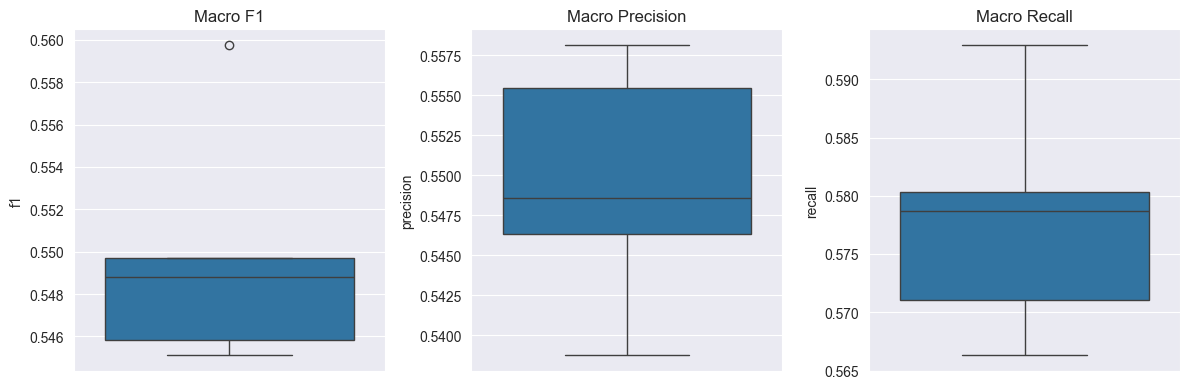

Average F1: 0.5498 ± 0.0059
Average Precision: 0.5495 ± 0.0077
Average Recall: 0.5779 ± 0.0102


In [29]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); sns.boxplot(y=df["f1"]); plt.title("Macro F1")
plt.subplot(1,3,2); sns.boxplot(y=df["precision"]); plt.title("Macro Precision")
plt.subplot(1,3,3); sns.boxplot(y=df["recall"]); plt.title("Macro Recall")
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "metrics_boxplots.png"))
plt.show()

print(f"Average F1: {df['f1'].mean():.4f} ± {df['f1'].std():.4f}")
print(f"Average Precision: {df['precision'].mean():.4f} ± {df['precision'].std():.4f}")
print(f"Average Recall: {df['recall'].mean():.4f} ± {df['recall'].std():.4f}")

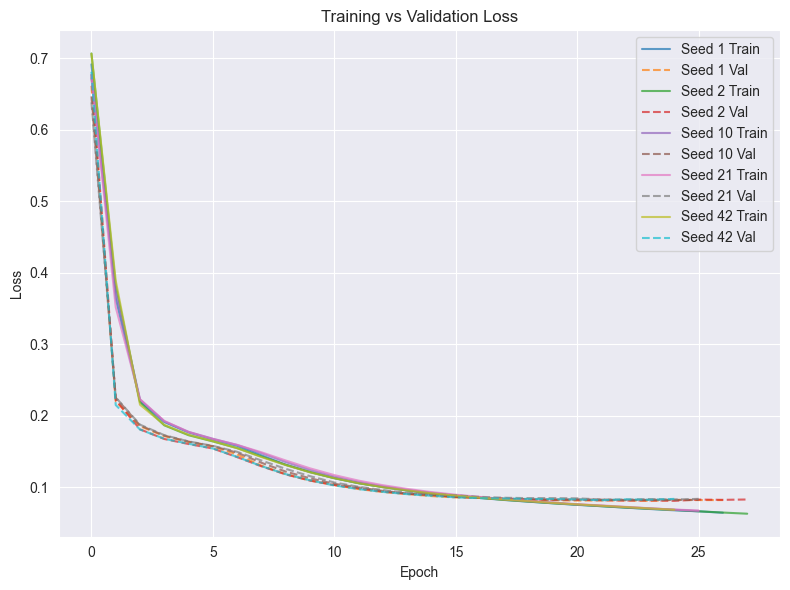

In [30]:
plt.figure(figsize=(8,6))
for res in all_results:
    plt.plot(res["train_losses"], label=f"Seed {res['seed']} Train", alpha=0.7)
    plt.plot(res["val_losses"], label=f"Seed {res['seed']} Val", alpha=0.7, linestyle="--")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training vs Validation Loss")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "loss_curves_roberta_early_fusion.png"))
plt.show()